## **Résumé**
Dans ce document, nous allons élaborer des modèles machine learning permettant de prédire le fait qu'un tweet annonce un désastre ou non.
Cette analyse se base sur des données de [Kaggle de tweets](https://www.kaggle.com/competitions/nlp-getting-started/data) composée comme suit :
- `id` - identifiant unique de chaque tweet
- `text` - le contenu du tweet
- `location` - le lieu de provenance du tweet
- `keyword` - un mot clé particulier du tweet
- `target` - indique si le tweet est en rapport avec un désastre (1) ou non (0)

Ce travail suit le plan suivant :    
- Importation et exploration des données
- Création de corpus
- Nétoyage du texte (suppression de la ponctuation, des caractères spéciaux, des chiffres, des espaces supplémentaires, etc)
- Tokennisation (n_gram - 1_gram, 2_gram, 3_gram -)
- Suppression des Stopwords ; Lemmatisation
- Vectorisation
- Prédiction (algorithme, optimisation des hyperparamètres, analyse de la modélisation)
- Evaluation des modèles & Choix du meilleur modèle

##**Importation des libraries**


In [60]:
!pip install pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis

In [61]:
pip install ydata-profiling

In [62]:
import re
import warnings
from collections import Counter

import os
from pathlib import Path
import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn import set_config
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from wordcloud import WordCloud

set_config(display="diagram", print_changed_only=False)
# filter warnings
warnings.filterwarnings('ignore')

## **Importation et Exploration des données**

In [63]:
# Définition du répertoire de travail
HOME_DIR = Path(Path(Path(Path(Path.cwd(), "drive"), "MyDrive"), "Colab Notebooks"), "Projet ML2")
DATA_DIR = Path(HOME_DIR, "data")
print(f"Work directory: {HOME_DIR} \nData directory: {DATA_DIR}")

Work directory: /content/drive/MyDrive/Colab Notebooks/Projet ML2 
Data directory: /content/drive/MyDrive/Colab Notebooks/Projet ML2/data


In [64]:
# importation de la base
data = pd.read_csv(Path(DATA_DIR, "train.csv"), sep=",")
data.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [65]:
data_validation = pd.read_csv(Path(DATA_DIR, "test.csv"), sep=",")
data_validation.head()

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

In [66]:
data['target_name'] = data['target'].replace({0: 'nodisaster', 1: 'disaster'})
data.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target target_name  
0       1    disaster  
1       1    disaster  
2       1    disaster  
3       1    disaster  
4       1    disaster

**Information sur la base**

In [67]:
data_profile = ProfileReport(data, title="Description du jeu de données")
data_profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

La base utilisée ici contient un total de 7613 tweets.

Les variables `keyword` et `location` contiennent respectivement 0.8% et 33.3% de valeurs manquantes. On note égalemnent un total de 3341 localisations distincts et 221 mots clés distincts. Cependant, ces informations ne seront pas utilisées dans l'analyse des tweets, la modélisation et la prédiction des désatre annoncés dans les tweets. Ces 2 variables seront par conséquent supprimées.

En ce qui concerne les tweets, on note la présence de 1.6% de tweets doublons. De plus, il y a une forte présence des mots "the", "a", "to", "in", "of", "and", "for", "on" d'après le diagramme des mots. Ces derniers sont en général considérés comme des stopwords de la langue anglaise. Cela nous amène donc à au nétoyage du corpus présent.

In [68]:
DataValidation_profile = ProfileReport(data_validation, title="Description du jeu de données")
DataValidation_profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Répartition des cibles**

In [69]:
label_distribution = data[["target", "target_name"]].value_counts(normalize = True).mul(100).round(2)
label_distribution

target  target_name
0       nodisaster     57.03
1       disaster       42.97
Name: proportion, dtype: float64

<Axes: xlabel='target,target_name'>

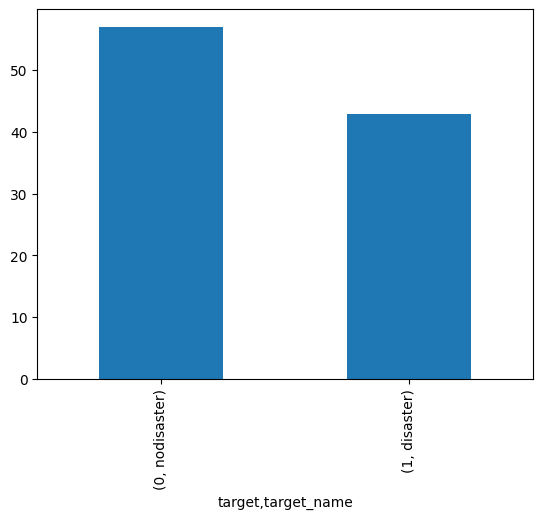

In [70]:
label_distribution.plot(kind="bar", )

La répartition n'est pas déséquilibrée. Elle est d'ailleurs assez égalitaire par rapport aux 2 cibles (distater et nodisaster)

In [71]:
#keyword_distribution = data[["keyword"]].value_counts(normalize = True).mul(100).round(2)
#location_distribution = data[["location"]].value_counts(normalize = True).mul(100).round(2)

#print(keyword_distribution)
#print("\n")
#print(location_distribution)

### **`Keyword` détermine-t-elle `target` ?**

In [72]:
# Convertir les colonnes en chaînes de caractères
data['keyword'] = data['keyword'].astype(str)
data['text'] = data['text'].astype(str)

# Fonction pour vérifier la présence du mot dans le texte
def word_in_text(row):
    return int(row['keyword'].lower() in row['text'].lower())

# Appliquer la fonction à chaque ligne du DataFrame
data['keyword_in_text'] = data.apply(word_in_text, axis=1)

data.head()

id keyword location                                               text  \
0   1     nan      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     nan      NaN             Forest fire near La Ronge Sask. Canada   
2   5     nan      NaN  All residents asked to 'shelter in place' are ...   
3   6     nan      NaN  13,000 people receive #wildfires evacuation or...   
4   7     nan      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target target_name  keyword_in_text  
0       1    disaster                0  
1       1    disaster                0  
2       1    disaster                0  
3       1    disaster                0  
4       1    disaster                0

In [73]:
data[data["keyword"] != "nan"]['keyword_in_text'].value_counts(normalize= True)

keyword_in_text
1    0.790916
0    0.209084
Name: proportion, dtype: float64

Dans 79% des cas, le mot clé est dans le tweet. Il se pourrait qu'il identifie suffisamment bien la nature "disaster" ou "nodisaster" du tweet

In [74]:
disaster_keyword = data[data['target'] == 1]['keyword']
nodisaster_keyword = data[data['target'] == 0]['keyword']
#nodisaster_keyword.value_counts()
#disaster_keyword.value_counts()

In [75]:
# Convertir les listes en ensembles
set1 = set(disaster_keyword)
set2 = set(nodisaster_keyword)

# Trouver les mots en commun
common_words = set1 & set2

# Compter le nombre de mots en commun
num_common_words = len(common_words)

print("Mots en commun:", common_words)
print("Nombre de mots en commun:", num_common_words)
print("Nombre de keyword en tweet disaster:", len(disaster_keyword.unique()))
print("Nombre de keyword en tweet nodisaster:", nodisaster_keyword.nunique())

Mots en commun: {'crash', 'wounds', 'landslide', 'apocalypse', 'flooding', 'trapped', 'meltdown', 'pandemonium', 'bloody', 'body%20bag', 'annihilated', 'quarantine', 'radiation%20emergency', 'exploded', 'siren', 'thunder', 'body%20bags', 'oil%20spill', 'injured', 'ambulance', 'terrorism', 'bridge%20collapse', 'cliff%20fall', 'demolished', 'disaster', 'ablaze', 'survivors', 'dust%20storm', 'buildings%20burning', 'bleeding', 'windstorm', 'survived', 'blown%20up', 'bomb', 'army', 'collided', 'survive', 'obliterated', 'weapon', 'blizzard', 'blew%20up', 'emergency', 'storm', 'devastated', 'burned', 'chemical%20emergency', 'suicide%20bomber', 'wild%20fires', 'drought', 'flood', 'bioterror', 'demolish', 'forest%20fires', 'electrocute', 'casualty', 'threat', 'fatal', 'wreck', 'bombed', 'destroyed', 'epicentre', 'blaze', 'thunderstorm', 'displaced', 'wrecked', 'deluged', 'police', 'seismic', 'crushed', 'lightning', 'snowstorm', 'explosion', 'burning%20buildings', 'sinkhole', 'accident', 'mudsli

Il n'y a pas une grande différence entre les mots clés des tweets de chaque catégorie.

In [76]:
from scipy.stats import chi2_contingency
import numpy as np

# Créer une table de contingence
contingency_table = pd.crosstab(data['keyword'], data['target'])
# Afficher la table de contingence
print("Table de contingence :")
print(contingency_table)
# Calculer le test du chi carré
chi2, p, dof, expected = chi2_contingency(contingency_table)
# Afficher les résultats
print(f"\nChi2: {chi2}, p-value: {p}")

# Calculer le V de Cramer
n = contingency_table.sum().sum()  # Nombre total d'échantillons
min_dim = min(contingency_table.shape) - 1  # La plus petite dimension de la table de contingence
cramers_v = np.sqrt(chi2 / (n * min_dim))
# Affichage des résultats
print(f"\nV de Cramer: {cramers_v}")


Table de contingence :
target                0   1
keyword                    
ablaze               23  13
accident             11  24
aftershock           34   0
airplane%20accident   5  30
ambulance            18  20
...                  ..  ..
wounded              11  26
wounds               23  10
wreck                30   7
wreckage              0  39
wrecked              36   3

[222 rows x 2 columns]

Chi2: 2282.777332726426, p-value: 0.0

V de Cramer: 0.5475879225004032


In [77]:
from scipy.stats import chi2_contingency
import numpy as np

# Créer une table de contingence
contingency_table = pd.crosstab(data['keyword'], data['target_name'])
# Afficher la table de contingence
print("Table de contingence :")
print(contingency_table)
# Calculer le test du chi carré
chi2, p, dof, expected = chi2_contingency(contingency_table)
# Afficher les résultats
print(f"\nChi2: {chi2}, p-value: {p}")

# Calculer le V de Cramer
n = contingency_table.sum().sum()  # Nombre total d'échantillons
min_dim = min(contingency_table.shape) - 1  # La plus petite dimension de la table de contingence
cramers_v = np.sqrt(chi2 / (n * min_dim))
# Afficher les résultats
print(f"\nV de Cramer: {cramers_v}")

Table de contingence :
target_name          disaster  nodisaster
keyword                                  
ablaze                     13          23
accident                   24          11
aftershock                  0          34
airplane%20accident        30           5
ambulance                  20          18
...                       ...         ...
wounded                    26          11
wounds                     10          23
wreck                       7          30
wreckage                   39           0
wrecked                     3          36

[222 rows x 2 columns]

Chi2: 2282.777332726426, p-value: 0.0

V de Cramer: 0.5475879225004032


Le test de Chi2 révèle une dépendance entre les mots clés des tweets et la nature "disaster" ou "nodisaster" du tweets. Le V de Cramer estime l'intensité de cette relation à seulement 54.76%

## **Corpus**

**Base utile**

In [78]:
u_data = data.copy()
data = data[["id", "text",	"target",	"target_name"]]
data = data.drop_duplicates(subset='text', keep='first', inplace=False)

In [79]:
duplicated_rows = u_data[u_data.duplicated(subset='text', keep=False)]
duplicated_rows

id     keyword        location  \
40       59      ablaze  Live On Webcam   
48       68      ablaze  Live On Webcam   
106     156  aftershock              US   
115     165  aftershock              US   
118     171  aftershock     Switzerland   
...     ...         ...             ...   
7600  10855         nan             NaN   
7607  10867         nan             NaN   
7609  10870         nan             NaN   
7610  10871         nan             NaN   
7611  10872         nan             NaN   

                                                   text  target target_name  \
40    Check these out: http://t.co/rOI2NSmEJJ http:/...       0  nodisaster   
48    Check these out: http://t.co/rOI2NSmEJJ http:/...       0  nodisaster   
106   320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...       0  nodisaster   
115   320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...       0  nodisaster   
118   320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...       0  nodisaster   
...                                                 ...     ...         ...   
7600  Evacuation order lifted for town of Roosevelt:...       1    disaster   
7607  #stormchase Violent Record Breaking EF-5 El Re...       1    disaster   
7609  @aria_ahrary @TheTawniest The out of control w...       1    disaster   
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1    disaster   
7611  Police investigating after an e-bike collided ...       1    disaster   

      keyword_in_text  
40                  0  
48                  0  
106                 1  
115                 1  
118                 1  
...               ...  
7600                0  
7607                0  
7609                0  
7610                0  
7611                0  

[179 rows x 7 columns]

In [80]:
data = data.drop_duplicates(subset='text', keep='first', inplace=False)

**Représentation**

In [81]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

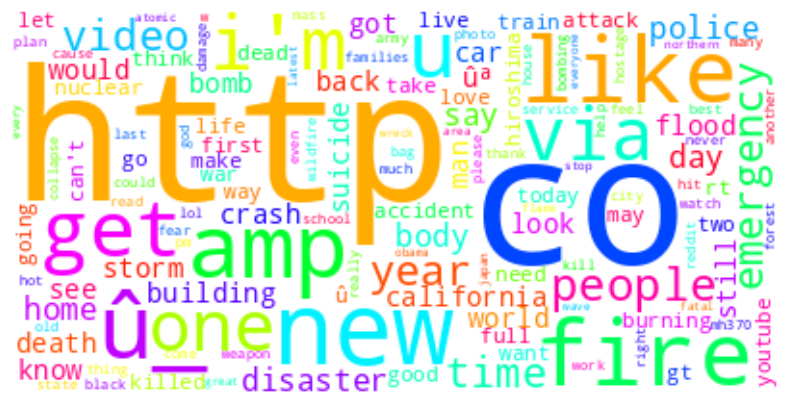

In [82]:
# Create a word_cloud from words and frequencies.

# get all verbatim
all_text = " ".join(data.text.str.lower())
words_frequency = Counter(all_text.split())

# stopwords of english language
stopwords_nltk = set(stopwords.words('english'))

# function for world cloud
def display_wordcloud(corpus, title=""):
    plt.figure(figsize=(10, 5))
    wc = WordCloud(background_color="white",
                   max_words=1000,
                   colormap='hsv',
                   stopwords=stopwords_nltk,
                   collocations=False)
    # generate word cloud
    #wc.generate_from_frequencies(words_frequency)
    wc.generate_from_text(corpus)
    plt.imshow(wc, interpolation="bilinear")
    plt.title(title)
    plt.axis("off");

# word cloud displaying
display_wordcloud(corpus=all_text)

Empty DataFrame
Columns: []
Index: []

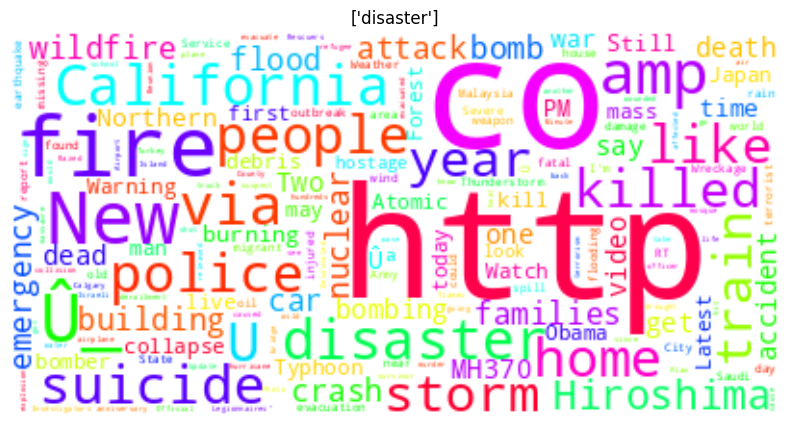

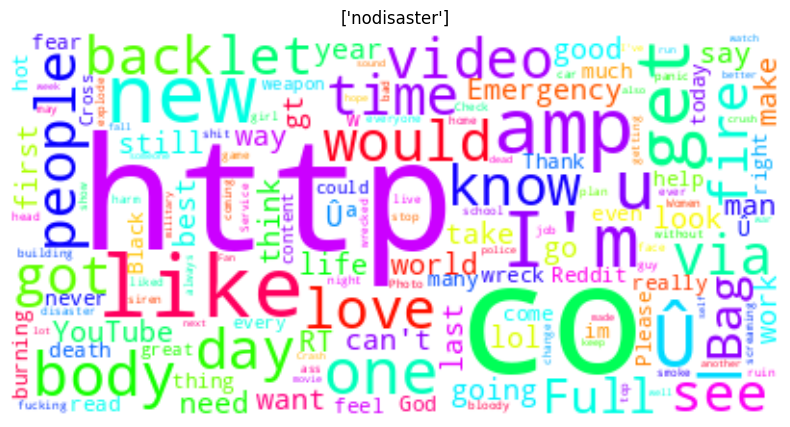

In [83]:
# wordcloud by target
data.groupby("target_name").apply(
    lambda group: display_wordcloud(" ".join(group.text), title=group.target_name.unique()))

### **Preprocessing du texte - nétoyage, stopwords, lemmatisation, stemmatisation, tokennisation**

***Function de preprocessing du texte***

In [84]:
def preprocess_text(text, language="english", stopwords=None, normalizer="stem"):

    valid_normalizer = (None, "stem", "lemma")
    if not normalizer in valid_normalizer:
        raise ValueError(f"`normalizer` must be in `{valid_normalizer}`")
    # lower case
    text = text.lower()

    # delete html balise
    # We can also use BeautifulSoup package to get the text from HTML document
    text = re.sub(re.compile('<.*?>'), '', text)

    # remove url
    text = re.sub(r'(http|www)\S*', '', text)

    # delete email
    text = re.sub(r"\S*@\S*\s*", "", text)

    # delete special character
    text = re.sub(r'[^\w\s]', '', text)

    # delete number
    text = re.sub(r'[0-9]+','', text).strip()

    # tokenizer
    text_tokens = word_tokenize(text)

    # remove stopword
    if isinstance(stopwords, (set, list, tuple)):
        # split sentence word by word
        text_tokens = [word for word in text_tokens if word not in stopwords]

    # stem string: snowball stemmer
    if normalizer == "stem":
        stemmer = SnowballStemmer(language, ignore_stopwords=True)
        text_tokens = [stemmer.stem(wrd) for wrd in text_tokens]
    elif normalizer == "lemma":
        lemmatizer = WordNetLemmatizer()
        text_tokens = [lemmatizer.lemmatize(wrd) for wrd in text_tokens]

    return " ".join(text_tokens)

***Formation du corpus***

In [85]:
%%time
# add new column for sanitizing
data["text_sanitize"] = data.text.apply(preprocess_text, stopwords=stopwords_nltk, normalizer=None)
data["text_sanitize_stem"] = data.text.apply(preprocess_text, stopwords=stopwords_nltk, normalizer="stem")
data["text_sanitize_lemma"] = data.text.apply(preprocess_text, stopwords=stopwords_nltk, normalizer="lemma")
data["text_sanitize_lemma_stem"] = data.text_sanitize_lemma.apply(preprocess_text, stopwords=stopwords_nltk, normalizer="stem")

CPU times: user 14.8 s, sys: 530 ms, total: 15.3 s
Wall time: 21.2 s


***Représentation du corpus***

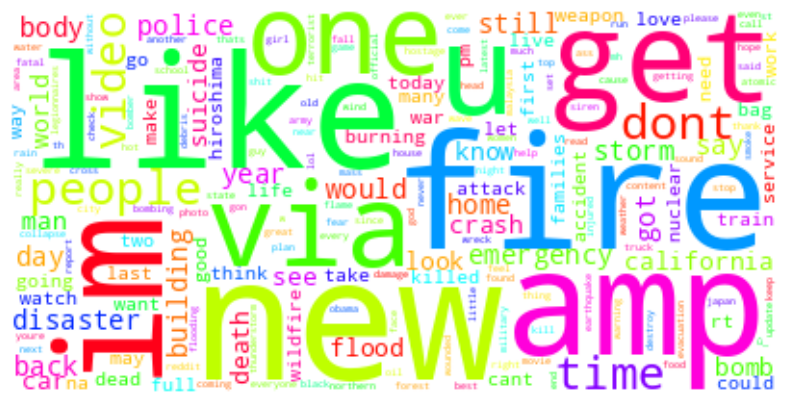

In [86]:
all_text_sanitize = " ".join(data.text_sanitize)
display_wordcloud(corpus=all_text_sanitize)

Empty DataFrame
Columns: []
Index: []

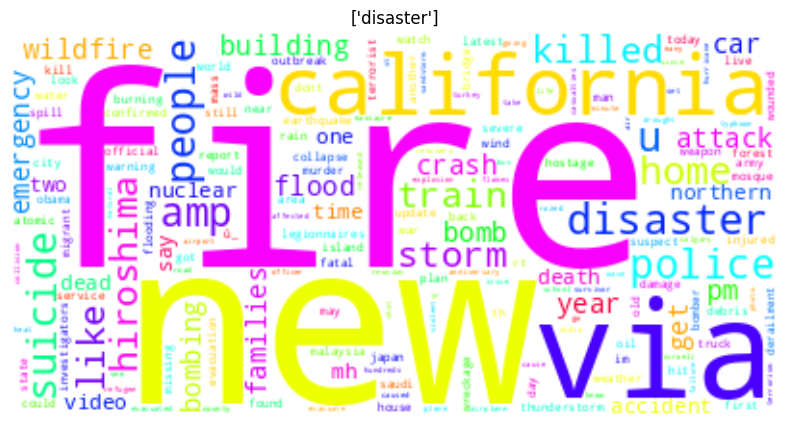

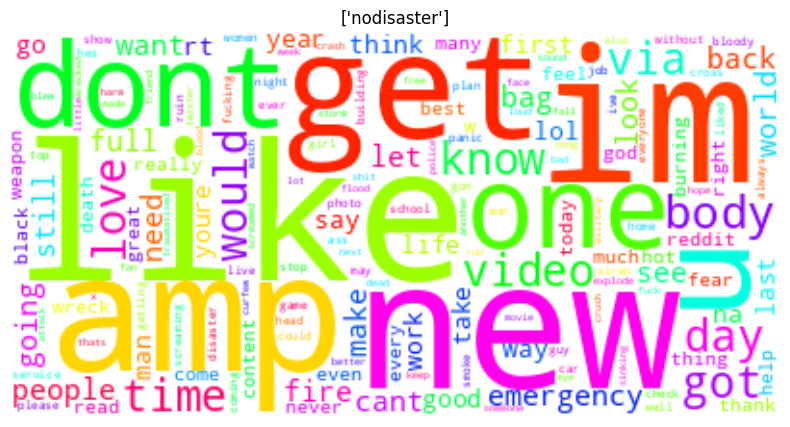

In [87]:
data.groupby("target_name").apply(
    lambda group: display_wordcloud(" ".join(group.text_sanitize), title=group.target_name.unique()))

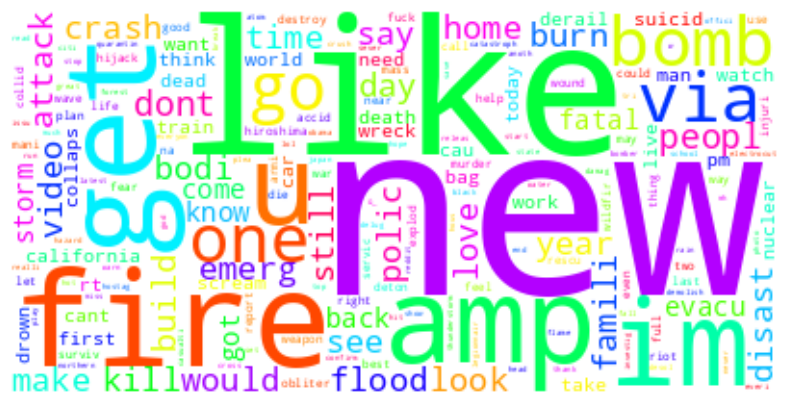

In [88]:
all_text_sanitize_stem = " ".join(data.text_sanitize_stem)
display_wordcloud(corpus=all_text_sanitize_stem)

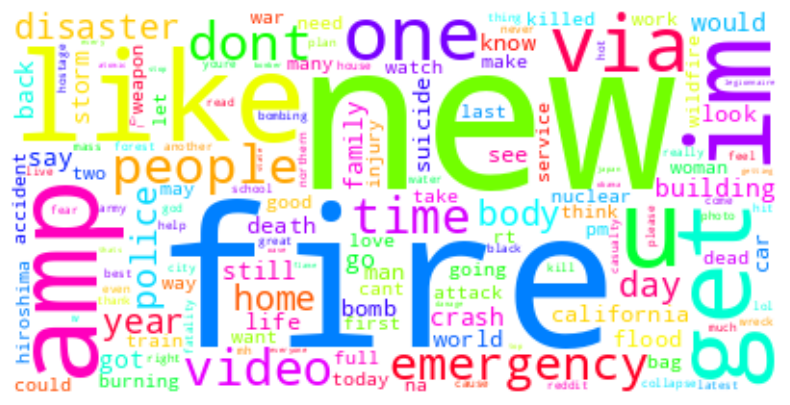

In [89]:
all_text_sanitize_lemma = " ".join(data.text_sanitize_lemma)
display_wordcloud(corpus=all_text_sanitize_lemma)

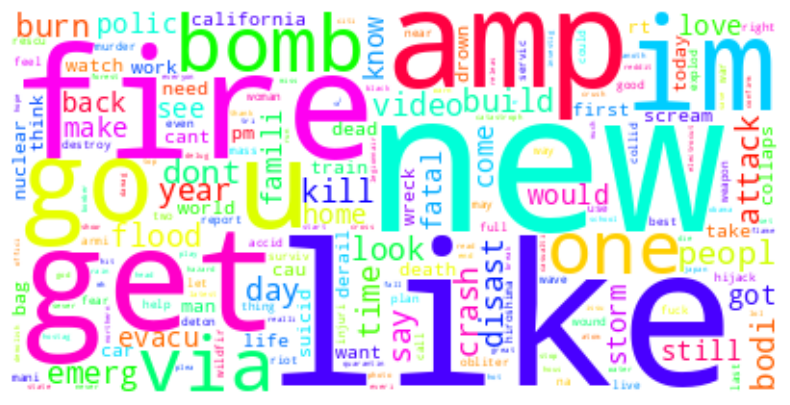

In [90]:
all_text_sanitize_lemma_stem = " ".join(data.text_sanitize_lemma_stem)
display_wordcloud(corpus=all_text_sanitize_lemma_stem)

***Exportation de la base utile***

In [91]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.makedirs('/content/drive/MyDrive/Colab Notebooks/Projet ML2/data', exist_ok=True)

data.to_csv(
    '/content/drive/MyDrive/Colab Notebooks/Projet ML2/data/UsefulData.csv',  # Nom du fichier
    index=False,          # Ne pas écrire l'index
    sep=',',              # Séparateur de champ (par défaut ',')
    encoding='utf-8',     # Encodage du fichier
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Modélisation**

Elle peut se faire de 2 manières :
- Dans le cas présent, étant donné que le prétraitement à déjà été effectué, on peut continuer ainsi, faire une vectorisation et une modélisation simultanément dans le pipeline
- Dans un autre cas et dans une optique de déployement, il serait possible d'intégrer le prétraitement dans le pipeline

### **Test de modélisation**

#### **Vectorisation**

In [92]:
# get all tweets (corpus)
target = data.target
corpus_none = data.text_sanitize # corpus non normalisé
corpus_stem = data.text_sanitize_stem # corpus normalisé par stemmatisation
corpus_lemma = data.text_sanitize_lemma # corpus normalisé par lemmatisation
corpus_lemma_stem = data.text_sanitize_lemma_stem # corpus normalisé par lemmatisation et ensuite par stemmatisation

**Vectoriser avec le Bag of Word**

In [93]:
# vectorisation avec BoW en utilisant un corpus non normalisé et des token unigramme
count_vect = CountVectorizer(binary=True, ngram_range = (1,1))
X_train_none = count_vect.fit_transform(corpus_none)

In [94]:
# vectorisation avec BoW en utilisant un corpus non normalisé et des token unigramme et bigramme
count_vect = CountVectorizer(binary=True, ngram_range = (1,2))
X_train_12none = count_vect.fit_transform(corpus_none)

In [95]:
# vectorisation avec BoW en utilisant un corpus normalisé par stemmatisation et des token unigramme
count_vect = CountVectorizer(binary=True, ngram_range = (1,1))
X_train_strem = count_vect.fit_transform(corpus_stem)

In [96]:
# vectorisation avec BoW en utilisant un corpus normalisé par lemmatisation et des token unigramme
count_vect = CountVectorizer(binary=True, ngram_range = (1,1))
X_train_lemma = count_vect.fit_transform(corpus_lemma)

In [97]:
# vectorisation avec BoW en utilisant un corpus normalisé par lemmatisation et par stemmatisation et des token unigramme
count_vect = CountVectorizer(binary=True, ngram_range = (1,1))
X_train_lemma_stem = count_vect.fit_transform(corpus_lemma_stem)

**Vectoriser avec Td-IDF**

In [98]:
# vectorisation avec TF-IDF en utilisant un corpus non normalisé et des token unigramme
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stopwords_nltk), max_df=0.95,
                                   min_df=0.025, ngram_range=(1, 1))
X_train_TFnone = tfidf_vectorizer.fit_transform(corpus_none)

In [99]:
# vectorisation avec TF-IDF en utilisant un corpus non normalisé et des token unigramme et bigramme
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stopwords_nltk), max_df=0.95,
                                   min_df=0.025, ngram_range=(1, 2))
X_train_TF12none = tfidf_vectorizer.fit_transform(corpus_none)

In [100]:
# vectorisation avec TF-IDF en utilisant un corpus normalisé par stemmatisation et des token unigramme
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stopwords_nltk), max_df=0.95,
                                   min_df=0.025, ngram_range=(1, 1))
X_train_TFstrem = tfidf_vectorizer.fit_transform(corpus_stem)

In [101]:
# vectorisation avec TF-IDF en utilisant un corpus normalisé par lemmatisation et des token unigramme
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stopwords_nltk), max_df=0.95,
                                   min_df=0.025, ngram_range=(1, 1))
X_train_TFlemma = tfidf_vectorizer.fit_transform(corpus_lemma)

In [102]:
# vectorisation avec TF-IDF en utilisant un corpus normalisé par lemmatisation et par stemmatisation et des token unigramme
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stopwords_nltk), max_df=0.95,
                                   min_df=0.025, ngram_range=(1, 1))
X_train_TFlemma_stem = tfidf_vectorizer.fit_transform(corpus_lemma_stem)

#### **Modélisation**

***BoW***

In [103]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (accuracy_score, classification_report,
                             roc_auc_score, confusion_matrix)

# Création et entraînement du classifieur
clf = BernoulliNB().fit(X_train_none, target)
# train prediction
y_train_pred = clf.predict(X_train_none)
# train report
print(classification_report(target, y_train_pred))

fbeta = fbeta_score(target, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      4305
           1       0.95      0.81      0.87      3198

    accuracy                           0.90      7503
   macro avg       0.91      0.89      0.89      7503
weighted avg       0.90      0.90      0.90      7503

F-beta score (beta=1.75): 0.839172181134034


In [104]:
# Création et entraînement du classifieur
clf = BernoulliNB().fit(X_train_12none, target)
# train prediction
y_train_pred = clf.predict(X_train_12none)
# train report
print(classification_report(target, y_train_pred))

fbeta = fbeta_score(target, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      4305
           1       0.99      0.85      0.91      3198

    accuracy                           0.93      7503
   macro avg       0.94      0.92      0.93      7503
weighted avg       0.94      0.93      0.93      7503

F-beta score (beta=1.75): 0.8791049982558428


In [105]:
# Création et entraînement du classifieur
clf = BernoulliNB().fit(X_train_strem, target)
# train prediction
y_train_pred = clf.predict(X_train_strem)
# train report
print(classification_report(target, y_train_pred))

fbeta = fbeta_score(target, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      4305
           1       0.93      0.80      0.86      3198

    accuracy                           0.89      7503
   macro avg       0.90      0.88      0.88      7503
weighted avg       0.89      0.89      0.89      7503

F-beta score (beta=1.75): 0.8264609271258698


In [106]:
# Création et entraînement du classifieur
clf = BernoulliNB().fit(X_train_lemma, target)
# train prediction
y_train_pred = clf.predict(X_train_lemma)
# train report
print(classification_report(target, y_train_pred))

fbeta = fbeta_score(target, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      4305
           1       0.95      0.80      0.87      3198

    accuracy                           0.90      7503
   macro avg       0.91      0.88      0.89      7503
weighted avg       0.90      0.90      0.90      7503

F-beta score (beta=1.75): 0.8342746328931717


In [107]:
# Création et entraînement du classifieur
clf = BernoulliNB().fit(X_train_lemma_stem, target)
# train prediction
y_train_pred = clf.predict(X_train_lemma_stem)
# train report
print(classification_report(target, y_train_pred))

fbeta = fbeta_score(target, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      4305
           1       0.93      0.80      0.86      3198

    accuracy                           0.89      7503
   macro avg       0.90      0.88      0.88      7503
weighted avg       0.89      0.89      0.89      7503

F-beta score (beta=1.75): 0.8256853248115045


***TF-IDF***

In [108]:
# Création et entraînement du classifieur
clf = BernoulliNB().fit(X_train_TFnone, target)
# train prediction
y_train_pred = clf.predict(X_train_TFnone)
# train report
print(classification_report(target, y_train_pred))

fbeta = fbeta_score(target, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.59      0.97      0.73      4305
           1       0.64      0.08      0.15      3198

    accuracy                           0.59      7503
   macro avg       0.61      0.52      0.44      7503
weighted avg       0.61      0.59      0.48      7503

F-beta score (beta=1.75): 0.10508653104216933


In [109]:
# Création et entraînement du classifieur
clf = BernoulliNB().fit(X_train_TF12none, target)
# train prediction
y_train_pred = clf.predict(X_train_TF12none)
# train report
print(classification_report(target, y_train_pred))

fbeta = fbeta_score(target, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.59      0.97      0.73      4305
           1       0.64      0.08      0.15      3198

    accuracy                           0.59      7503
   macro avg       0.61      0.52      0.44      7503
weighted avg       0.61      0.59      0.48      7503

F-beta score (beta=1.75): 0.10508653104216933


In [110]:
# Création et entraînement du classifieur
clf = BernoulliNB().fit(X_train_TFstrem, target)
# train prediction
y_train_pred = clf.predict(X_train_TFstrem)
# train report
print(classification_report(target, y_train_pred))

fbeta = fbeta_score(target, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.61      0.94      0.74      4305
           1       0.69      0.18      0.29      3198

    accuracy                           0.62      7503
   macro avg       0.65      0.56      0.51      7503
weighted avg       0.64      0.62      0.55      7503

F-beta score (beta=1.75): 0.22023788515158998


In [111]:
# Création et entraînement du classifieur
clf = BernoulliNB().fit(X_train_TFlemma, target)
# train prediction
y_train_pred = clf.predict(X_train_TFlemma)
# train report
print(classification_report(target, y_train_pred))

fbeta = fbeta_score(target, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.60      0.95      0.73      4305
           1       0.66      0.13      0.22      3198

    accuracy                           0.60      7503
   macro avg       0.63      0.54      0.47      7503
weighted avg       0.62      0.60      0.51      7503

F-beta score (beta=1.75): 0.16243962076446405


In [112]:
# Création et entraînement du classifieur
clf = BernoulliNB().fit(X_train_TFlemma_stem, target)
# train prediction
y_train_pred = clf.predict(X_train_TFlemma_stem)
# train report
print(classification_report(target, y_train_pred))

fbeta = fbeta_score(target, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.61      0.94      0.74      4305
           1       0.69      0.18      0.29      3198

    accuracy                           0.62      7503
   macro avg       0.65      0.56      0.51      7503
weighted avg       0.64      0.62      0.55      7503

F-beta score (beta=1.75): 0.21991762283024416


Voyant les résultats ci-dessus, on soupçonne que la vectorisation par TF-IDF est peu efficace dans notre contexte. De plus on a un meilleur score avec un mélange d'unigrammes et de bigrammes.

## **Définition d'un pipeline**

Ledit pipeline intègrera le prétraitement d'un texte brute en sélectionnant les paramètres de prétraitement à utiliser. Il intègrera également le choix de la methode de vectorisation à utiliser ainsi que le modèle à entrainer.

**Fonction de vectorisation à inclure dans le pipeline**

In [113]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

class VectorizerSelector(BaseEstimator, TransformerMixin):
    def __init__(self, vectorizer='tfidf', maxdf=0.95, mindf=0.01, stopwords=None, ngram_range=(1, 1)):
        self.vectorizer = vectorizer
        self.maxdf = maxdf
        self.mindf = mindf
        self.stopwords = stopwords
        self.ngram_range = ngram_range

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Créer le vectorizer en fonction du type spécifié
        if self.vectorizer == 'tfidf':
            vectorizer = TfidfVectorizer(max_df=self.maxdf, min_df=self.mindf, stop_words=self.stopwords)
        elif self.vectorizer == 'count':
            vectorizer = CountVectorizer(ngram_range=self.ngram_range, binary=True)
        return vectorizer

In [124]:
class VectorizerSelector_ok(BaseEstimator, TransformerMixin):
    def __init__(self, vectorizer='tfidf', maxdf=0.95, mindf=0.01, stopwords=None, ngram_range=(1, 1)):
        self.vectorizer = vectorizer
        self.maxdf = maxdf
        self.mindf = mindf
        self.stopwords = stopwords
        self.ngram_range = ngram_range

    def fit(self, X, y=None):
        if self.vectorizer == 'tfidf':
            self.vectorizer_ = TfidfVectorizer(max_df=self.maxdf, min_df=self.mindf, stop_words=self.stopwords, ngram_range=self.ngram_range)
        elif self.vectorizer == 'count':
            self.vectorizer_ = CountVectorizer(ngram_range=self.ngram_range, binary=True, stop_words=self.stopwords)
        self.vectorizer_.fit(X)
        return self

    def transform(self, X, y=None):
        return self.vectorizer_.transform(X)


**Fonction de Text-Preprocessing à inclure dans le pipeline**

In [114]:
from sklearn.base import BaseEstimator, TransformerMixin

# fonction de préprocessing
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, language="english", stopwords_list=None, normalizer="stem"):
        self.language = language
        self.stopwords_list = stopwords_list
        self.normalizer = normalizer

    def preprocess_text(self, text):
        # Paramètres de prétraitement
        language = self.language
        stopwords_list = self.stopwords_list
        normalizer = self.normalizer

        # Votre fonction de prétraitement ici
        valid_normalizer = (None, "stem", "lemma")
        if not normalizer in valid_normalizer:
            raise ValueError(f"`normalizer` must be in `{valid_normalizer}`")
        # lower case
        text = text.lower()

        # delete html balise
        # We can also use BeautifulSoup package to get the text from HTML document
        text = re.sub(re.compile('<.*?>'), '', text)

        # remove url
        text = re.sub(r'(http|www)\S*', '', text)

        # delete email
        text = re.sub(r"\S*@\S*\s*", "", text)

        # delete special character
        text = re.sub(r'[^\w\s]', '', text)

        # delete number
        text = re.sub(r'[0-9]+','', text).strip()

        # tokenizer
        text_tokens = word_tokenize(text)

        # remove stopword
        if isinstance(stopwords_list, (set, list, tuple)):
            # split sentence word by word
            text_tokens = [word for word in text_tokens if word not in stopwords_list]

        # stem string: snowball stemmer
        if normalizer == "stem":
            stemmer = SnowballStemmer(language, ignore_stopwords=True)
            text_tokens = [stemmer.stem(wrd) for wrd in text_tokens]
        elif normalizer == "lemma":
            lemmatizer = WordNetLemmatizer()
            text_tokens = [lemmatizer.lemmatize(wrd) for wrd in text_tokens]

        return " ".join(text_tokens)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [self.preprocess_text(text) for text in X]

**Définition du pipeline avec prétraitement**

In [115]:
from sklearn.pipeline import Pipeline

# Whole / Complete Pipeline
WPipeline_NB = Pipeline([
        ('preprocessor', TextPreprocessor()),
        ('vectorizer', VectorizerSelector_ok()),
        ('classifier', BernoulliNB())
    ])

WPipeline_NB

Pipeline(memory=None,
         steps=[('preprocessor',
                 TextPreprocessor(language='english', normalizer='stem',
                                  stopwords_list=None)),
                ('vectorizer',
                 VectorizerSelector(maxdf=0.95, mindf=0.01, ngram_range=(1, 1),
                                    stopwords=None, vectorizer='tfidf')),
                ('classifier',
                 BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                             fit_prior=True, force_alpha='warn'))],
         verbose=False)

**Définition du pipeline sans prétraitement**

In [125]:
# Restricted Pipeline
RPipeline_NB = Pipeline([
        ('vectorizer', VectorizerSelector_ok()),
        ('classifier', BernoulliNB())
    ])

RPipeline_NB

Pipeline(memory=None,
         steps=[('vectorizer',
                 VectorizerSelector_ok(maxdf=0.95, mindf=0.01,
                                       ngram_range=(1, 1), stopwords=None,
                                       vectorizer='tfidf')),
                ('classifier',
                 BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                             fit_prior=True, force_alpha='warn'))],
         verbose=False)

## **Subdivision du dataset en `train` et `test`**

In [126]:
from sklearn.model_selection import train_test_split

#array.reshape(-1, 1)
#Splitting data as train, test, validation
X_train, X_test, y_train, y_test = train_test_split(data["text_sanitize"], target, test_size=0.25, random_state=42)

### **Fiting & Performances**

In [127]:
RPipeline_NB.fit(X_train, y_train)
NB_predicted = RPipeline_NB.predict(X_test)

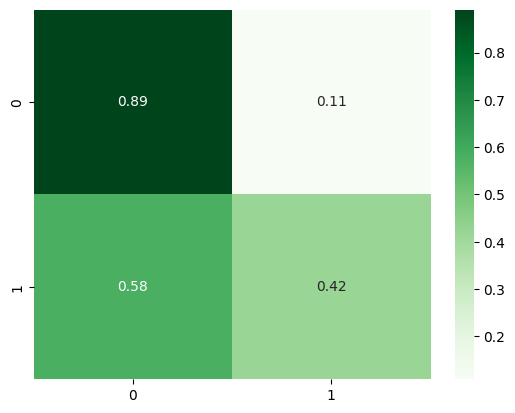

In [128]:
sns.heatmap(confusion_matrix(y_test, NB_predicted, normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [132]:
print(classification_report(y_test, NB_predicted,
                            target_names={"nodisaster" : 0, "disaster" : 1}))

fbeta = fbeta_score(y_test, NB_predicted, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

  nodisaster       0.68      0.89      0.77      1100
    disaster       0.73      0.42      0.53       776

    accuracy                           0.70      1876
   macro avg       0.71      0.65      0.65      1876
weighted avg       0.70      0.70      0.67      1876

F-beta score (beta=1.75): 0.46794701399964567


### **Optimisation des hyperparamètres**

**Hyperparamètres**

In [135]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score

# Définir la grille de paramètres
param_grid = {
    'vectorizer__vectorizer': ['tfidf', 'count'],
    'vectorizer__stopwords': [None, list(stopwords_nltk)],
    'vectorizer__maxdf': [0.85, 0.90, 0.95],
    'vectorizer__mindf': [0.01, 0.02, 0.025],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'classifier__alpha': [0.05, 0.1, 0.2, 0.5, 1.0, 10.0]
}

# Créer un scorer personnalisé pour F-beta avec beta=1.75
fbeta_scorer = make_scorer(fbeta_score, beta=1.75, average='weighted')

# Créer un StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Effectuer la recherche par grille
grid_search = GridSearchCV(RPipeline_NB, param_grid, cv=skf, n_jobs=-1, verbose=1, scoring=fbeta_scorer)

**Optimisation**

In [137]:
grid_search.fit(X_train, y_train)

print(f"Best f_1.75 score: {grid_search.best_score_}")
best_params = grid_search.best_params_
print(f"\nBest parameters: \n{best_params}")

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best f_1.75 score: 0.7974156808992605

Best parameters: 
{'classifier__alpha': 0.5, 'vectorizer__maxdf': 0.85, 'vectorizer__mindf': 0.01, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stopwords': None, 'vectorizer__vectorizer': 'count'}


**Meilleur prédicteur**

In [140]:
best_NB_predicted = Pipeline([
    ('vectorizer', VectorizerSelector_ok(
        vectorizer=best_params.get("vectorizer__vectorizer"),
        maxdf=best_params.get("vectorizer__maxdf"),
        mindf=best_params.get("vectorizer__mindf"),
        ngram_range=best_params.get("vectorizer__ngram_range"),
        stopwords=best_params.get("vectorizer__stopwords") #stopwords.words('english')  # Ajouter les stopwords ici si nécessaire
    )),
    ('classifier', BernoulliNB(
        alpha=best_params.get("classifier__alpha")  # Correction : BernoulliNB utilise 'alpha'
    ))
])
best_NB_predicted

Pipeline(memory=None,
         steps=[('vectorizer',
                 VectorizerSelector_ok(maxdf=0.85, mindf=0.01,
                                       ngram_range=(1, 1), stopwords=None,
                                       vectorizer='count')),
                ('classifier',
                 BernoulliNB(alpha=0.5, binarize=0.0, class_prior=None,
                             fit_prior=True, force_alpha='warn'))],
         verbose=False)

**Evaluation d'apprentissage**

In [142]:
# train prediction
y_train_pred = best_NB_predicted.fit(X_train, y_train).predict(X_train)
# train report
print(classification_report(y_train, y_train_pred))
# f_beta score
fbeta = fbeta_score(y_train, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      3205
           1       0.96      0.86      0.91      2422

    accuracy                           0.93      5627
   macro avg       0.93      0.92      0.92      5627
weighted avg       0.93      0.93      0.92      5627

F-beta score (beta=1.75): 0.883338767525269


**Evaluation de prédiction**

In [143]:
# test set
print(classification_report(y_test, best_NB_predicted.predict(X_test)))

fbeta = fbeta_score(y_test, best_NB_predicted.predict(X_test), beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1100
           1       0.81      0.64      0.71       776

    accuracy                           0.79      1876
   macro avg       0.79      0.77      0.77      1876
weighted avg       0.79      0.79      0.78      1876

F-beta score (beta=1.75): 0.6756136249791285
